<a href="https://colab.research.google.com/github/moritzbrantner/ites/blob/master/01_1_Model_Basics_Overfitting_MLflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basics of Deep Learning Projects


Subject of this notebook is to teach fundamental properties of deep learning projects. It is important being able to reproduce different runs of model training, as well as different runs should be comparable to each other. For this, we will use [MLflow](https://mlflow.org/), which is an open source platform to manage the ML lifecycle, including experimentation, reproducibility and deployment. It currently offers three components:

* MLflow Tracking: Record and query experiments: code, data, config, and results.
* MLflow Projects: Packaging format for reproducible runs on any platform.
* MLflow Models: General format for sending models to diverse deployment tools.

ToDo's:

* Define different neural networks using `tf.keras`.
* Train them and monitor the training using TensorBoard and MLflow
* Try to intentionally overfit the training set. There are multiple ways to achieve this. 
* Compare different runs using MLflow. Can you spot the point where overfitting happened?


Help:
* [TensorFLow API Documentation](https://www.tensorflow.org/api_docs)
* [MLflow Documentation](https://mlflow.org/docs/latest/index.html)


In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Mount Google Drive as folder

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/My\ Drive/Master/Modul\ Maschinelles\ Lernen/INFM\ 220/ai-lab/cv/colab

Mounted at /content/drive
/content/drive/My Drive/Master/Modul Maschinelles Lernen/INFM 220/ai-lab/cv/colab


# Check GPU

*   Google Colab can provide you with one of two Tesla graphics cards: K80 or T4
*   Here you can check the GPU model

In [7]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [0]:
%tensorflow_version 2.x

In [9]:
!pip install mlflow

     |████████████████████████████████| 16.0MB 268kB/s 
     |████████████████████████████████| 92kB 9.7MB/s 
     |████████████████████████████████| 81kB 9.3MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 6.0MB 39.0MB/s 
     |████████████████████████████████| 153kB 43.7MB/s 
     |████████████████████████████████| 1.1MB 39.4MB/s 
     |████████████████████████████████| 460kB 40.2MB/s 
     |████████████████████████████████| 204kB 43.0MB/s 
     |████████████████████████████████| 81kB 9.8MB/s 
     |████████████████████████████████| 71kB 9.2MB/s 
  Created wheel for simplejson: filename=simplejson-3.17.0-cp36-cp36m-linux_x86_64.whl size=114200 sha256=9a03e624072c9a44d7c09abff394338d181c83072cf3c212434b454612046123
  Stored in directory: /root/.cache/pip/wheels/86/c0/83/dcd0339abb2640544bb8e0938aab2d069cef55e5647ce6e097
  Created wheel for databricks-cli: filename=databricks_cli-0.10.0-cp36-none-any.whl size=84285 sha256=e4d60bb1ed071

In [10]:
import tensorflow as tf
import mlflow
import numpy as np

tf.__version__

'2.2.0-rc2'

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Set Experiment, so that we get all the results for this exercise grouped together.
mlflow.set_experiment("Exercise 1: Fashion MNIST")

In [0]:
# ToDo: load the dataset from the file `data/fashion_mnist.npz`. 
# The data accesible using the key `data`, the labels as `label` respectively.
with np.load('../data/fashion_mnist.npz') as fashion:
    x = fashion["data"]
    y = fashion["label"]

In [0]:
import math

def shuffle_split(x, y, at=0.8):
    x_reshaped = x.reshape(70000, 784)
    y_reshaped = y.reshape(70000, 1)
    df = np.c_[x_reshaped, y_reshaped]
    df_shuffled = np.random.shuffle(df)
    
    size = df.shape[0]
    cut = math.floor(df.shape[0] * at)
    df_train = df[0:cut]
    df_test = df[cut:]
    x_train = np.delete(df_train, 784, 1).reshape(cut, 28, 28) 
    x_test = np.delete(df_test, 784, 1).reshape(size-cut, 28, 28)
    y_train = df_train[:,  [784]].reshape(cut)   
    y_test = df_test[:,  [784]].reshape(size-cut)
    return x_train, x_test, y_train, y_test
    # ToDo: shuffle data and labels and perform train/test split at given fraction.

x_train, x_test, y_train, y_test = shuffle_split(x, y, at=0.8)

In [0]:
def normalize(data):
  return (data.mean(axis=0) - data) / data.std(axis=0)

# ToDo: normalize data
x_train = normalize(x_train)
x_test = normalize(x_test)

In [16]:
# print first 15 labels
for i in range(15):
    if i % 5 == 0:
        print("\n")
    print(y_train[i], end=' ')



5 8 1 8 8 

5 2 8 2 4 

4 5 7 0 3 

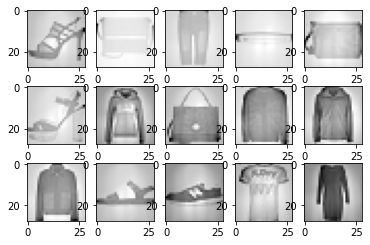

In [17]:
# plots the first 15 entries in the train set
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')

In [0]:
# ToDo: define input and output network parameters
n_input =  (1, 28, 28)
n_classes = 10

In [0]:
# one hot encoding of labels
def one_hot_encode(a, length):
    temp = np.zeros((a.shape[0], length))
    temp[np.arange(a.shape[0]), a] = 1
    return temp

y_train = one_hot_encode(y_train, n_classes)
y_test = one_hot_encode(y_test, n_classes)

In [0]:
# Flatten
x_train = x_train.reshape((-1, 784))
x_test = x_test.reshape((-1, 784))

In [0]:
# TODO: define hyper parameters
training_iters = 20
learning_rate = 0.001
batch_size = 10

In [0]:
from tensorflow.python.keras.layers import Dense, Conv2D
from tensorflow.python.keras import Sequential

# ToDo: MLP definition
model = tf.keras.models.Sequential([
    Dense(64, activation='relu', input_shape=(784,))
])
model.add(Dense(10, activation='softmax'))

In [0]:
# ToDo: define cost
cost = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
# define optimizer
optimizer = tf.keras.optimizers.Adam(0.01)

In [0]:
# TODO: compile model with optimizer, loss function and validation metric
model.compile(optimizer=optimizer,
              loss=cost,
              metrics=['accuracy'])

In [25]:
# ToDo: Train your model and evaluate on holdout test set
import mlflow.tensorflow as mltf

mltf.autolog(every_n_iter=1)
#model.build(784)
model.fit(x=x_train, y=y_train, epochs=training_iters)
score = model.evaluate(x=x_test, y=y_test)
score

/usr/local/lib/python3.6/dist-packages/mlflow/utils/autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/20
1750/1750 [==============================] - 4s 2ms/step - loss: 1.8002 - accuracy: 0.6605
Epoch 2/20
1750/1750 [==============================] - 4s 2ms/step - loss: 1.8166 - accuracy: 0.6444
Epoch 3/20
1750/1750 [==============================] - 4s 2ms/step - loss: 1.8307 - accuracy: 0.6303
Epoch 4/20
1750/1750 [==============================] - 4s 2ms/step - loss: 1.8107 - accuracy: 0.6505
Epoch 5/20
1750/1750 [==============================] - 4s 2ms/step - loss: 1.8198 - accuracy: 0.6414
Epoch 6/20
1750/1750 [==============================] - 4s 2ms/step - loss: 1.8207 - accuracy: 0.6404
Epoch 7/20
1750/1750 [==============================] - 4s 2ms/step - loss: 1.8366 - accuracy: 0.6246
Epoch 8/20
1750/1750 [==============================] - 4s 2ms/step - loss: 1.8167 - accuracy: 0.6444
Epoch 9/20
1750/1750 [==============================] - 4s 2ms/step - loss: 1.8091 - accuracy: 0.6520
Epoch 10/20
1750/1750 [==============================] - 4s 2ms/step - loss: 1.825

Using TensorFlow backend.


438/438 [==============================] - 1s 1ms/step - loss: 1.8027 - accuracy: 0.6583


[1.802692174911499, 0.6582857370376587]